In [2]:
import pandas as pd
import utm
import folium
from folium.plugins import MarkerCluster, HeatMap
import numpy as np
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
import urllib.request
import json
import math

In [104]:
df = pd.read_csv('database.csv',encoding='latin1', quotechar='"')
df.tail()

,ID,PROVINCE_CODE,PROVINCE,CITY_CODE,CITY,MAGNETIC ANOMALY,LITOLOGI_CODE,LITOLOGI,MINERAL_CODE,MINERAL_POTENTIAL,INFORMATION,DATA_SOURCE,EASTING,NORTHING,LAT,LON
2790,2791,17,Bengkulu,NaN,Bengkuku Selatan,NaN,NaN,NaN,24,Titan Plaser,"Kadar Fe 35,18-58,05%; TiO2 6,35 - 9,49%","Kanwil DPE Bengkulu, Hasil Survey awal 2000.",690488.7339,49588.96606,-4.083453,102.480469
2791,2792,19,Kepulauan Bangka Belitung,NaN,Bangka Tengah,NaN,NaN,NaN,24,Titan Plaser,Ilmenit sebagai produk sampingan timah sampai ...,"PT Koba Tin, Surat Tanggal 25 Agustus 2004",690488.7339,49588.96606,-2.547988,106.655273
2792,2793,34,Daerah Istimewa Yogyakarta,NaN,Kulon Progo,NaN,NaN,NaN,25,Vanadium,"Logam ikutan pasir besi, kadar V2O5 12,8 - 13,...","PT Jogja Mangasa Iron, Laporan Akhir Kajian Ke...",690488.7339,49588.96606,-7.928675,110.126953
2793,2794,19,Kepulauan Bangka Belitung,NaN,Belitung,NaN,NaN,NaN,26,Xenotim,Koluvial (logam),NaN,690488.7339,49588.96606,-2.767478,108.193359
2794,2795,19,Kepulauan Bangka Belitung,NaN,Belitung Timur,NaN,NaN,NaN,26,Xenotim,Plaser dengan kadar Al2O3=25-30%,"PT Timah, Tbk, Tinjauan Potensi REE di WIUP PT...",690488.7339,49588.96606,-2.943041,108.281250


In [93]:
for idx,row in df.iterrows():
    a = utm.to_latlon(row['EASTING'],row['NORTHING'],49,'M')
    df['LAT'][idx] = a[0]
    df['LON'][idx] = a[1]

df.head()

KeyError: 'NORTHIN'

In [68]:
'''
for idx,row in df.iterrows():
    a = utm.from_latlon(row['lat'],row['lon'])
    df['easting'] = a[0]
    df['northing'] = a[1]

df.to_csv('database.csv', index=False)
'''

In [102]:
m2 = folium.Map([df.LAT.mean(), df.LON.mean()], tiles='openstreetmap',zoom_start=10)
HeatMap(data=df[['LAT','LON']], radius=10).add_to(m2)
'''
def PlotDot(point):
    folium.CircleMarker(location=[point.LAT, point.LON],
                        radius=5,
                        weight=2,
                        popup=[point.MINERAL_POTENTIAL,point.CITY,point.PROVINCE],
                        fill_color='#000000').add_to(m2)
df.apply(PlotDot,axis=1)
'''
m2.fit_bounds(m2.get_bounds())
m2.save('test-peta.html')
m2

In [43]:
df = pd.read_csv('database.csv',encoding='latin1', quotechar='"')

def plot_density(source):
    map = folium.Map([source.LAT.mean(), source.LON.mean()], tiles='Stamen Terrain',zoom_start=10)
    HeatMap(data=source[['LAT','LON']], radius=20).add_to(map)
    
    def PlotDot(point):
        folium.Circle(location=[point.LAT, point.LON],
                        radius=4,
                        popup=point.MINERAL_POTENTIAL,
                        color='#7FFF5F'
                        ).add_to(map)

    source.apply(PlotDot,axis=1)
    map.fit_bounds(map.get_bounds())
    map.save(r'D:\Fajrul\Internship\Hackathon MIND ID\Interactive Map\Map {}.html'.format(source.MINERAL_POTENTIAL.values[0]))

for i in range(26):
    data = df[df.MINERAL_CODE == i+1]
    plot_density(data)

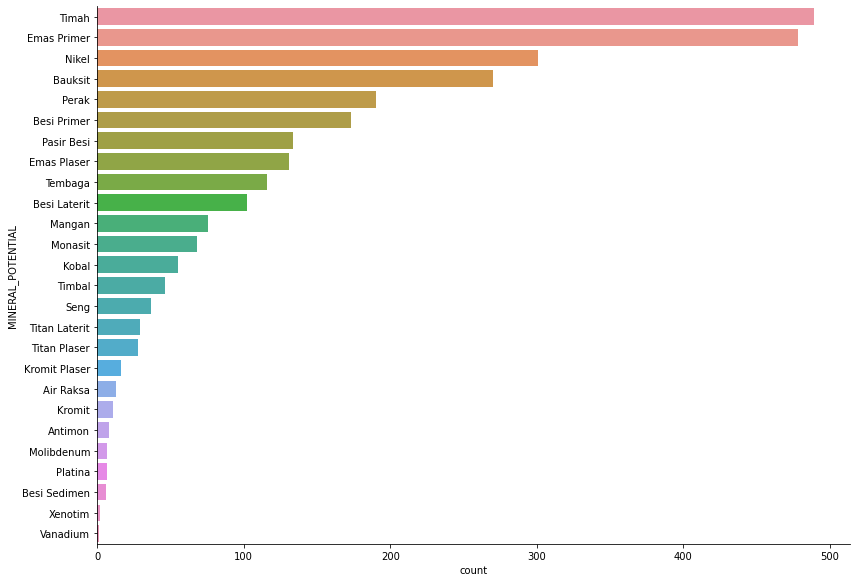

In [96]:
import seaborn as sns
sns.catplot(y='MINERAL_POTENTIAL',
            kind='count',
            height=8,
            aspect=1.5,
            order=df.MINERAL_POTENTIAL.value_counts().index,
            data=df)

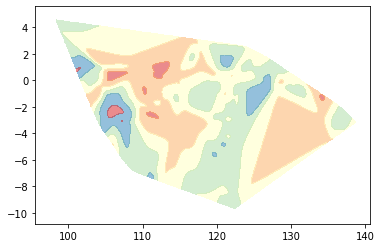

In [111]:
# Setup
temp_mean = 12
temp_std  = 2
debug     = False
 
# Create a dataframe with fake data
data = pd.DataFrame({
    'longitude': df['LON'],
    'latitude':  df['LAT'],
    'depth': df['MINERAL_CODE'].astype('float')})

# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=data['depth'].min(), vmax=data['depth'].max()).to_step(levels)
 
# The original data
x_orig = np.asarray(data.longitude.tolist())
y_orig = np.asarray(data.latitude.tolist())
z_orig = np.asarray(data.depth.tolist())
 
# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
 
# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
 
# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)
 
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)
 
# Set up the folium plot
geomap = folium.Map([data.latitude.mean(), data.longitude.mean()], zoom_start=6, tiles="openstreetmap")
 
# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)
 
# Add the colormap to the folium map
cm.caption = 'KODE MINERAL'
geomap.add_child(cm)
 
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
geomap

In [6]:

#START-END POINT
P1=[-8.121266,111.283962]
P2=[-8.109244,111.285014]

#NUMBER OF POINTS
s=100
interval_lat=(P2[0]-P1[0])/s #interval for latitude
interval_lon=(P2[1]-P1[1])/s #interval for longitude

#SET A NEW VARIABLE FOR START POINT
lat0=P1[0]
lon0=P1[1]

#LATITUDE AND LONGITUDE LIST
lat_list=[lat0]
lon_list=[lon0]

#GENERATING POINTS
for i in range(s):
    lat_step=lat0+interval_lat
    lon_step=lon0+interval_lon
    lon0=lon_step
    lat0=lat_step
    lat_list.append(lat_step)
    lon_list.append(lon_step)

In [7]:
#HAVERSINE FUNCTION
def haversine(lat1,lon1,lat2,lon2):
    lat1_rad=math.radians(lat1)
    lat2_rad=math.radians(lat2)
    lon1_rad=math.radians(lon1)
    lon2_rad=math.radians(lon2)
    delta_lat=lat2_rad-lat1_rad
    delta_lon=lon2_rad-lon1_rad
    a=math.sqrt((math.sin(delta_lat/2))**2+math.cos(lat1_rad)*math.cos(lat2_rad)*(math.sin(delta_lon/2))**2)
    d=2*6371000*math.asin(a)
    return d

#DISTANCE CALCULATION
d_list=[]
for j in range(len(lat_list)):
    lat_p=lat_list[j]
    lon_p=lon_list[j]
    dp=haversine(lat0,lon0,lat_p,lon_p)/1000 #km
    d_list.append(dp)
d_list_rev=d_list[::-1] #reverse list


In [8]:
#CONSTRUCT JSON
d_ar=[{}]*len(lat_list)
for i in range(len(lat_list)):
    d_ar[i]={"latitude":lat_list[i],"longitude":lon_list[i]}
location={"locations":d_ar}
json_data=json.dumps(location,skipkeys=int).encode('utf8')

#SEND REQUEST
url="https://api.open-elevation.com/api/v1/lookup"
response = urllib.request.Request(url,json_data,headers={'Content-Type': 'application/json'})
fp=urllib.request.urlopen(response)    

In [9]:
#RESPONSE PROCESSING
res_byte=fp.read()
res_str=res_byte.decode("utf8")
js_str=json.loads(res_str)
#print (js_mystr)
fp.close()

#GETTING ELEVATION 
response_len=len(js_str['results'])
elev_list=[]
for j in range(response_len):
    elev_list.append(js_str['results'][j]['elevation'])

#BASIC STAT INFORMATION
mean_elev=round((sum(elev_list)/len(elev_list)),3)
min_elev=min(elev_list)
max_elev=max(elev_list)
distance=d_list_rev[-1]

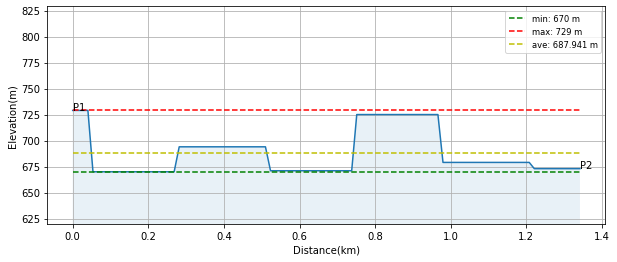

In [19]:
#PLOT ELEVATION PROFILE
base_reg=0
plt.figure(figsize=(10,4))
plt.plot(d_list_rev,elev_list)
plt.plot([0,distance],[min_elev,min_elev],'--g',label='min: '+str(min_elev)+' m')
plt.plot([0,distance],[max_elev,max_elev],'--r',label='max: '+str(max_elev)+' m')
plt.plot([0,distance],[mean_elev,mean_elev],'--y',label='ave: '+str(mean_elev)+' m')
plt.fill_between(d_list_rev,elev_list,base_reg,alpha=0.1)
plt.text(d_list_rev[0],elev_list[0],"P1")
plt.text(d_list_rev[-1],elev_list[-1],"P2")
plt.xlabel("Distance(km)")
plt.ylabel("Elevation(m)")
plt.ylim(min(elev_list)-50,max(elev_list)+100)
plt.grid()
plt.legend(fontsize='small')
plt.show()

In [15]:
min(elev_list)

670